In [1]:
# 2019.06.19.WED.~ 06.22.SAT.
# 
# DARPA Network Log Dataset of KDD 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# kddcup.data_10_percent.gz A 10% subset. (2.1M; 75M Uncompressed)
# 42 features
# add to timesteps
# Anomaly detection with OneClassSVM 

In [2]:
import keras 
import keras.backend as K  # New 
import pandas as pd
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

import numpy as np
from numpy import mean, std  #New 
import matplotlib.pyplot as plt
import seaborn as sns

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

from scipy import stats 

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error #Mean squared error regression loss
from sklearn.metrics import mean_absolute_error # Mean absolute error regression loss
from sklearn.metrics import confusion_matrix, recall_score, precision_score
# New 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score  #NEW 

from keijzer import *  # New  --- keijzer.py  # conda install -c conda-forge tqdm 

from factor_analyzer import FactorAnalyzer   # $ conda install -c ets factor_analyzer

from keras.layers.noise import AlphaDropout  # ---- NEW ----- for selu        
from keras.activations import elu  # New ---------------------------

%matplotlib inline

title = 'KDD_Networky_Logs_AD_004_'  #  OneClasSVM based Anomaly Detection

Using TensorFlow backend.


In [3]:
# DARPA Network Log Dataset of KDD 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# kddcup.data_10_percent.gz A 10% subset. (2.1M; 75M Uncompressed)

train_df = pd.read_csv('kddcup.data_10_percent_corrected') # (494020, 42)  do not , sep=" ", header=None)

train_df.shape

(494020, 42)

In [4]:
# description of feature name
# http://kdd.ics.uci.edu/databases/kddcup99/task.html

train_df.columns =["duration",      # length (number of seconds) of the connection 
                   "protocol_type", # type of the protocol, e.g. tcp, udp, etc. 
                   "service",       # network service on the destination, e.g., http, telnet, etc. 
                   "flag",          # normal or error status of the connection 
                   "src_bytes",     # number of data bytes from source to destination 
                   "dst_bytes",     # number of data bytes from destination to source 
                   "land",          # 1 if connection is from/to the same host/port; 0 otherwise 
                   "wrong_fragment", # 	number of ``wrong'' fragments 
                   "urgent",         #  number of urgent packets 
                   "hot",            #  number of ``hot'' indicators
                   "num_failed_logins", # number of failed login attempts 
                   "logged_in",         # 1 if successfully logged in; 0 otherwise 
                   "num_compromised",   # number of ``compromised'' conditions 
                   "root_shell",        # 1 if root shell is obtained; 0 otherwise 
                   "su_attempted",      # 1 if ``su root'' command attempted; 0 otherwise 
                   "num_root",          # number of ``root'' accesses 
                   "num_file_creations",  # number of file creation operations 
                   "num_shells",          # number of operations on access control files 
                   "num_access_files",    # number of operations on access control files 
                   "num_outbound_cmds",   # number of outbound commands in an ftp session 
                   "is_host_login",       # 1 if the login belongs to the ``hot'' list; 0 otherwise 
                   "is_guest_login",      # 1 if the login is a ``guest''login; 0 otherwise 
                   "count",           # number of connections to the same host as the current connection in the past two seconds, Note: The following  features refer to these same-host connections.
                   "srv_count",       # number of connections to the same service as the current connection in the past two seconds, Note: The following features refer to these same-service connections. 
                   "serror_rate",     # % of connections that have ``SYN'' errors 
                   "srv_serror_rate", # % of connections that have ``SYN'' errors 
                   "rerror_rate",     # % of connections that have ``REJ'' errors 
                   "srv_rerror_rate", # % of connections that have ``REJ'' errors 
                   "same_srv_rate",   # % of connections to the same service 
                   "diff_srv_rate",   # % of connections to different services 
                   "srv_diff_host_rate",  #  % of connections to different hosts 
                   "dst_host_count",          # destination of ~ 
                   "dst_host_srv_count",      # destination of ~ 
                   "dst_host_same_srv_rate",   # destination of ~  
                   "dst_host_diff_srv_rate",   # destination of ~ 
                   "dst_host_same_src_port_rate", # destination of ~ 
                   "dst_host_srv_diff_host_rate", # destination of ~ 
                   "dst_host_serror_rate",     # destination of ~  
                   "dst_host_srv_serror_rate", # destination of ~ 
                   "dst_host_rerror_rate",     # destination of ~ 
                   "dst_host_srv_rerror_rate", # destination of ~ 
                   "label"]          # 

In [5]:
train_df.shape

(494020, 42)

In [6]:
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
# values of label = normal, ... => 0(normal), 1, 2, 3, 4 
newlabeldf = train_df['label'].replace(
    { 'normal.' : 0, 'neptune.' : 1 ,'back.': 1, 'land.': 1, 'pod.': 1, 
     'smurf.': 1, 'teardrop.': 1,'mailbomb.': 1, 'apache2.': 1, 'processtable.': 1, 
     'udpstorm.': 1, 'worm.': 1, 'ipsweep.' : 2,'nmap.' : 2,'portsweep.' : 2,   ### worm 1
     'satan.' : 2,'mscan.' : 2,'saint.' : 2,'ftp_write.': 3,'guess_passwd.': 3, 
     'imap.': 3,'multihop.': 3, 'phf.': 3,'spy.': 3,'warezclient.': 3, 
     'warezmaster.': 3,'sendmail.': 3,'named.': 3,'snmpgetattack.': 3, 'snmpguess.': 3, 
     'xlock.': 3,'xsnoop.': 3,'httptunnel.': 3,'buffer_overflow.': 4,'loadmodule.': 4,  ### overflow 4
     'perl.': 4,'rootkit.': 4,'ps.': 4,'sqlattack.': 4,'xterm.': 4})

train_df['label'] = newlabeldf
#df['target'] = newlabeldf
print(train_df['label'].head())  # num of 5 in label 

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64


In [8]:
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
duration                       494020 non-null int64
protocol_type                  494020 non-null object
service                        494020 non-null object
flag                           494020 non-null object
src_bytes                      494020 non-null int64
dst_bytes                      494020 non-null int64
land                           494020 non-null int64
wrong_fragment                 494020 non-null int64
urgent                         494020 non-null int64
hot                            494020 non-null int64
num_failed_logins              494020 non-null int64
logged_in                      494020 non-null int64
num_compromised                494020 non-null int64
root_shell                     494020 non-null int64
su_attempted                   494020 non-null int64
num_root                       494020 non-null int64
num_file_creations             494020 

In [10]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
train_df['protocol_type'] = le.fit_transform(train_df['protocol_type'])
train_df['service']= le.fit_transform(train_df['service'])
train_df['flag'] = le.fit_transform(train_df['flag'])

In [11]:
X = train_df.iloc[:,:41] 
y = train_df.iloc[:,-1] # 42, label 

In [12]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,22,9,239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
1,0,1,22,9,235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
2,0,1,22,9,219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,1,22,9,217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0
4,0,1,22,9,217,2032,0,0,0,0,...,59,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [13]:
train_df.shape

(494020, 42)

In [14]:
train_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

In [15]:
train_df.describe()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
count,494020.000000,494020.000000,494020.000000,494020.000000,4.940200e+05,4.940200e+05,494020.000000,494020.000000,494020.000000,494020.000000,...,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000
mean,47.979400,0.467131,23.408896,7.842444,3.025616e+03,8.685232e+02,0.000045,0.006433,0.000014,0.034519,...,188.666034,0.753779,0.030906,0.601936,0.006684,0.176754,0.176443,0.058118,0.057412,0.816279
std,707.747185,0.575606,13.538346,2.250855,9.882191e+05,3.304003e+04,0.006673,0.134805,0.005510,0.782103,...,106.040236,0.410781,0.109259,0.481309,0.042133,0.380593,0.380920,0.230590,0.230141,0.426068
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,14.000000,9.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,14.000000,9.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,42.000000,9.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,58329.000000,2.000000,65.000000,10.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


### Correlation Matrix 

C:\Users\USER\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Saving heatmap


<Figure size 432x288 with 0 Axes>

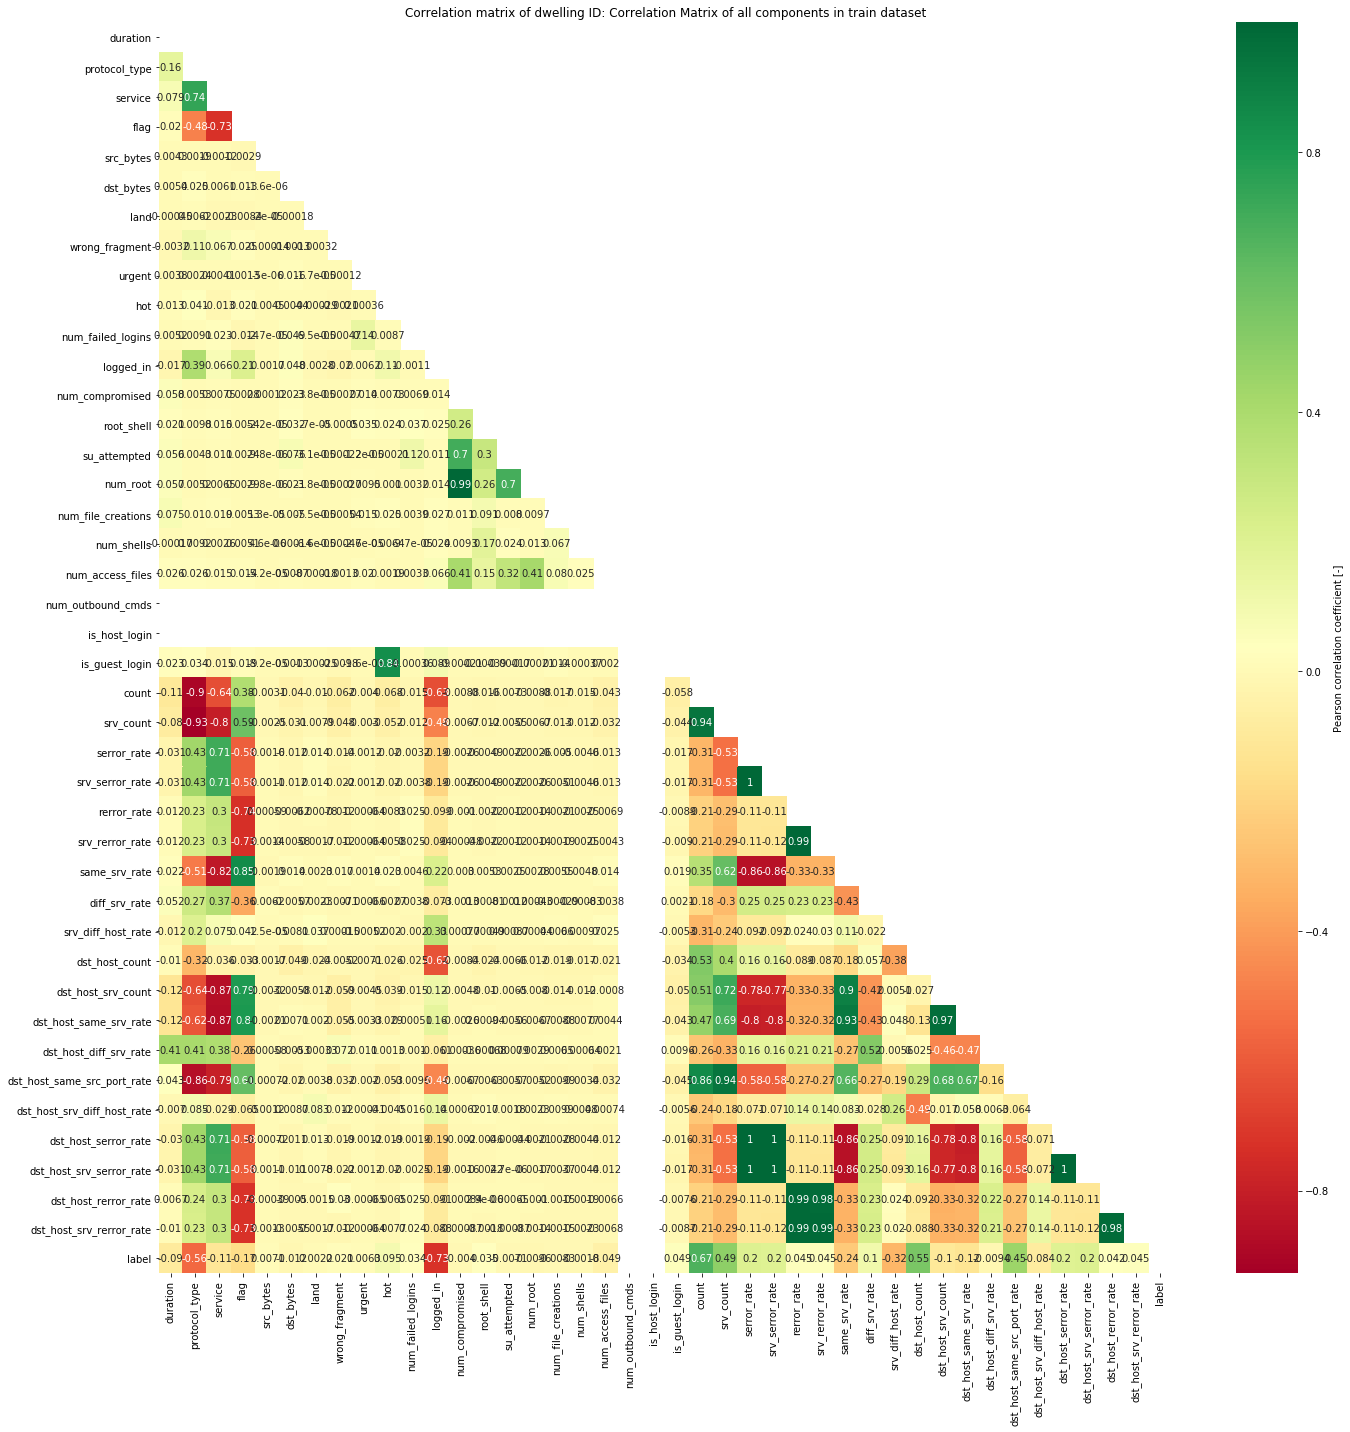

In [16]:
from keijzer import *     # (tensorflow-gpu) C:\Users\USER>conda install -c conda-forge tqdm
# 'Correlation Matrix of all components combined'
fig = create_corr_matrix(train_df, 'Correlation Matrix of all components in train dataset', True, size=(20,20))
fig.savefig(title+'cor_train_df1.png')

In [17]:
train_df['service'].describe()
#train_df['service'].value_counts()

count    494020.000000
mean         23.408896
std          13.538346
min           0.000000
25%          14.000000
50%          14.000000
75%          42.000000
max          65.000000
Name: service, dtype: float64

In [18]:
train_df['service'].value_counts()

14    281400
45    110893
22     64292
50      9723
40      7237
11      5863
19      4721
13      1642
18       798
17       670
61       538
56       513
39       380
3        328
43       202
59       157
6        126
47       120
20       117
24       117
10       116
9        116
55       115
25       115
49       112
12       112
48       111
65       110
51       110
44       109
       ...  
63       106
62       106
4        106
26       106
52       105
54       105
37       105
21       104
30       104
8        103
15       103
34       102
29       102
42       101
28       101
23        99
16        99
33        99
32        98
27        98
7         97
36        95
2         92
0         43
60        14
1         11
58         7
41         1
46         1
57         1
Name: service, Length: 66, dtype: int64

### Add to timestep, and time series plots

In [19]:
train_df.shape # 494020, 42

(494020, 42)

In [20]:
train_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

In [21]:
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,22,9,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
1,0,1,22,9,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
2,0,1,22,9,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,1,22,9,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0
4,0,1,22,9,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [22]:
#  %timeit  
# pip install jupyter_contrib_nbextensions
# jupyter contrib nbextension install --user
# jupyter nbextension enable execute_time/ExecuteTime

## Wall time: 7min 43s
# Using DataFrame.insert() to add a column 
# test_df.insert(0, "Age", [21, 23, 24, 21], True) # 0 > first, 2 > Thrid  

ts = pd.Series([])

num = 0
while num < len(train_df): # while num < len(494020) , 7min 43s
    num = num +1  # num += 1
    ts = ts.append(pd.Series(num), ignore_index = True) 
      
#print(s)

In [23]:
#  %timeit    
## Wall time: 1.99 ms

# train_df2 = train_df.copy()
# train_df2 = train_df2.insert(0, "timeseries", ts, True)
# pd.train_df2.to_csv('kddcup.data_10_percent.csv')

train_df.insert(0, "timeseries", ts, True)
#train_df2 = train_df.insert(0, "timeseries", ts, True)

In [24]:
#train_df2.shape  # 494020, 42 -> 43
train_df.shape

(494020, 43)

In [25]:
train_df.head()

,timeseries,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,1,0,1,22,9,239,486,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
1,2,0,1,22,9,235,1337,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
2,3,0,1,22,9,219,1337,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,4,0,1,22,9,217,2032,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0
4,5,0,1,22,9,217,2032,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [26]:
train_df.tail()

,timeseries,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
494015,494016,0,1,22,9,310,1881,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,0
494016,494017,0,1,22,9,282,2286,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,0
494017,494018,0,1,22,9,203,1200,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,0
494018,494019,0,1,22,9,291,1200,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,0
494019,494020,0,1,22,9,219,1234,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,0


In [27]:
# df['date_time'].min(), df['date_time'].max()

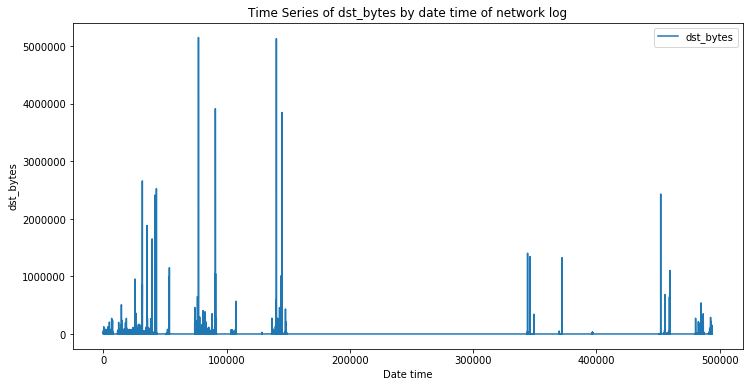

In [28]:
# plot the data
# df = df[['protocol_type', 'service', 'flag', 'logged_in', 'label']]
train_df.plot(x='timeseries', y='dst_bytes', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('dst_bytes')
plt.title('Time Series of dst_bytes by date time of network log');

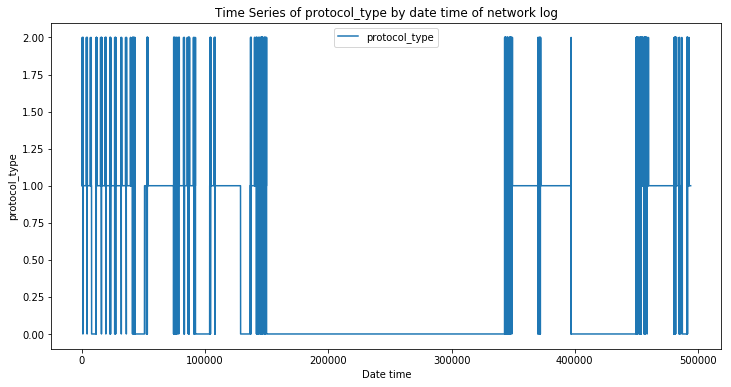

In [29]:
# plot the data
# df = df[['protocol_type', 'service', 'flag', 'logged_in', 'label']]
train_df.plot(x='timeseries', y='protocol_type', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('protocol_type')
plt.title('Time Series of protocol_type by date time of network log');

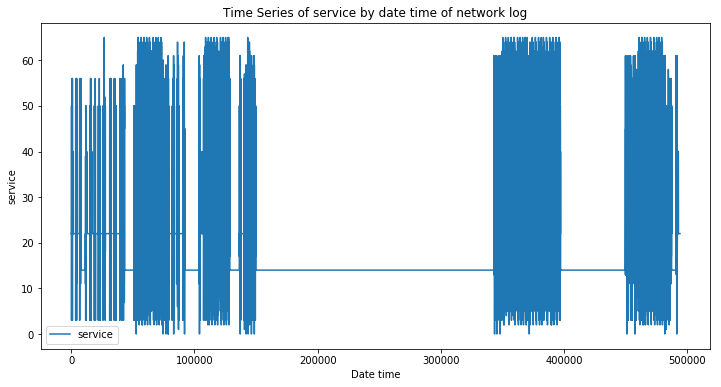

In [30]:
# plot the data
# df = df[['protocol_type', 'service', 'flag', 'logged_in', 'label']]
train_df.plot(x='timeseries', y='service', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('service')
plt.title('Time Series of service by date time of network log');

### Anomalous and Suspicious Conditions for Use Case Modeling

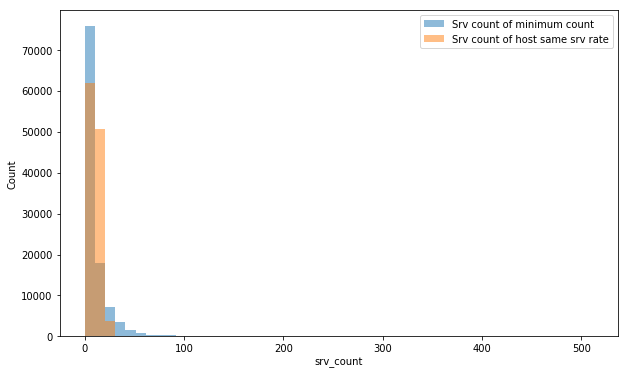

In [31]:
# Histogram 
a = train_df.loc[train_df['count'] < 100, 'srv_count']
b = train_df.loc[train_df['dst_host_same_srv_rate'] <0.1, 'srv_count']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Srv count of minimum count')
plt.hist(b, bins = 50, alpha=0.5, label='Srv count of host same srv rate')
plt.legend(loc='upper right')
plt.xlabel('srv_count')
plt.ylabel('Count')
plt.show();

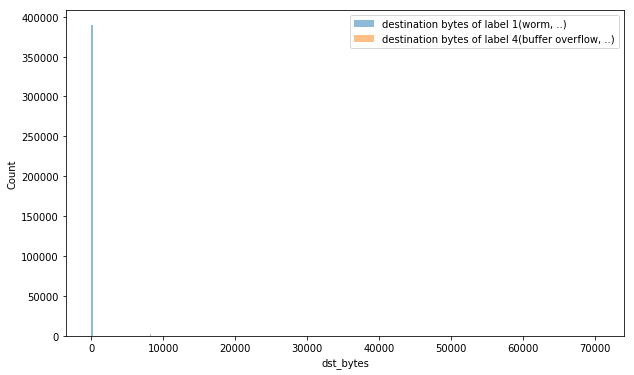

In [32]:
# Histogram 
#a = train_df.loc[train_df['srv_count'] < 200, 'dst_bytes']
b = train_df.loc[train_df['label'] == 1, 'dst_bytes']  # worm of label 1, buffer overflow of label 4
c = train_df.loc[train_df['label'] == 4, 'dst_bytes']  # worm of label 1, buffer overflow of label 4

plt.figure(figsize=(10, 6))

#plt.hist(a, bins = 50, alpha=0.5, label='Srv count of small count')
plt.hist(b, bins = 50, alpha=0.5, label='destination bytes of label 1(worm, ..)')
plt.hist(c, bins = 50, alpha=0.5, label='destination bytes of label 4(buffer overflow, ..)')

plt.legend(loc='upper right')
plt.xlabel('dst_bytes')
plt.ylabel('Count')
plt.show();

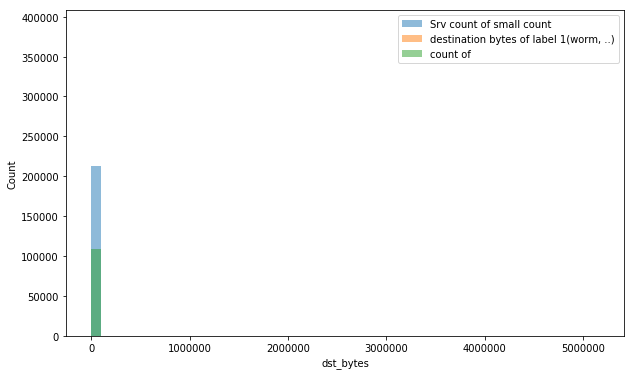

In [33]:
# Histogram 
a = train_df.loc[train_df['srv_count'] < 200, 'dst_bytes']
b = train_df.loc[train_df['label'] == 1, 'dst_bytes']  # worm of label 1, buffer overflow of label 4
# c = train_df.loc[train_df['label'] == 4, 'dst_bytes']  # worm of label 1, buffer overflow of label 4
d = train_df.loc[train_df['count'] < 100, 'dst_bytes']

plt.figure(figsize=(10, 6))

plt.hist(a, bins = 50, alpha=0.5, label='Srv count of small count')
plt.hist(b, bins = 50, alpha=0.5, label='destination bytes of label 1(worm, ..)')
#plt.hist(c, bins = 50, alpha=0.5, label='destination bytes of label 4(buffer overflow, ..)')
plt.hist(d, bins = 50, alpha=0.5, label='count of ')

plt.legend(loc='upper right')
plt.xlabel('dst_bytes')
plt.ylabel('Count')
plt.show();

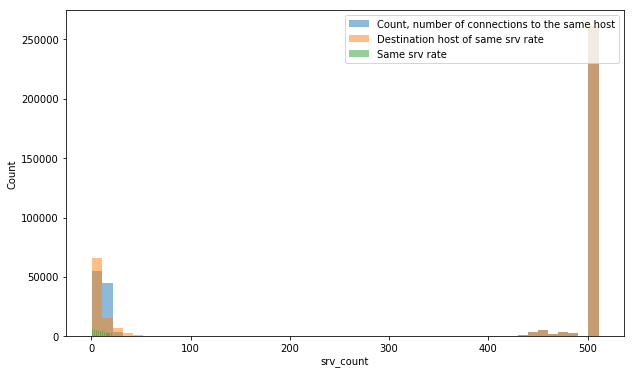

In [34]:
# Histogram 
#a = train_df.loc[df['srch_sat_night_bool'] == 0, 'price_usd']
#b = train_df.loc[df['srch_sat_night_bool'] == 1, 'price_usd']
a = train_df.loc[train_df['count'] > 100, 'srv_count']
b = train_df.loc[train_df['dst_host_same_srv_rate'] > 0.1, 'srv_count']
c = train_df.loc[train_df['same_srv_rate'] < 0.1, 'srv_count']

plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Count, number of connections to the same host')
plt.hist(b, bins = 50, alpha=0.5, label='Destination host of same srv rate')
plt.hist(c, bins = 50, alpha=0.5, label='Same srv rate')

plt.legend(loc='upper right')
plt.xlabel('srv_count')
plt.ylabel('Count')
plt.show();

In [35]:
# Histogram 

### Anomaly Detection by OneClassSVM 

In [36]:
# OneClassSVM - Warning: Consider pre-processing your data with StandardScaler or MinMaxScaler.
scaler = MinMaxScaler()
train_df = scaler.fit_transform(train_df)
train_df = pd.DataFrame(train_df)

C:\Users\USER\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [37]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.000000,0.0,0.5,0.338462,0.9,3.446905e-07,0.000094,0.0,0.0,0.0,...,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000002,0.0,0.5,0.338462,0.9,3.389216e-07,0.000259,0.0,0.0,0.0,...,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000004,0.0,0.5,0.338462,0.9,3.158461e-07,0.000259,0.0,0.0,0.0,...,0.152941,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000006,0.0,0.5,0.338462,0.9,3.129617e-07,0.000394,0.0,0.0,0.0,...,0.192157,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000008,0.0,0.5,0.338462,0.9,3.129617e-07,0.000394,0.0,0.0,0.0,...,0.231373,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
train_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
494015,0.999992,0.0,0.5,0.338462,0.9,4.470881e-07,0.000365,0.0,0.0,0.0,...,1.0,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,0.0
494016,0.999994,0.0,0.5,0.338462,0.9,4.067060e-07,0.000443,0.0,0.0,0.0,...,1.0,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,0.0
494017,0.999996,0.0,0.5,0.338462,0.9,2.927706e-07,0.000233,0.0,0.0,0.0,...,1.0,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,0.0
494018,0.999998,0.0,0.5,0.338462,0.9,4.196859e-07,0.000233,0.0,0.0,0.0,...,1.0,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,0.0
494019,1.000000,0.0,0.5,0.338462,0.9,3.158461e-07,0.000239,0.0,0.0,0.0,...,1.0,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,0.0


In [39]:
# %timeit  
# https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html
 
from sklearn.svm import OneClassSVM

#df = df.sort_values('date_time') # sort by timesteps
#df['date_time_int'] = df.date_time.astype(np.int64) 
#data = df[['col1', 'col2', 'col3']]
#scaler = StandardScaler()
#np_scaled = scaler.fit_transform(data)
#data = pd.DataFrame(np_scaled)

outliers_fraction = 0.25  # 4:1, default=0.5
# normal   1    380395
# anomaly -1    113625

# train oneclassSVM, OneClassSVM is just slow with high number of samples. 
model = OneClassSVM(nu=outliers_fraction, # the proportion of outliers,default=0.5,betweeh 0 and 1.  
                    kernel="rbf", # ‘rbf’ is nonlinear function, linear’, ‘poly’, ‘sigmoid’, 
                    gamma=0.1,    # "auto", 0.01, 0.001, 0.0001, a parameter of the RBF, effects the smoothness  
                    cache_size=4000, # default of 200(MB), such as 1000(MB) or 2000(MB).
                    max_iter=10,  # default -1 is no limit, Hard limit on iterations within solver. 
                    verbose=True) # verbose=True or False

# gamma default is ‘auto’ which uses 1/n_features, 1/40(43)=0.025, 1/20 = 0.05
# if gamma='scale' is passed then it uses 1/(n_features * X.var()) as value of gamma.
# https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use

# fitting of train, running time 03:15~04:15, 1hour. 
model.fit(train_df)

[LibSVM]

C:\Users\USER\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


OneClassSVM(cache_size=4000, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=10, nu=0.25, random_state=None, shrinking=True, tol=0.001,
      verbose=True)

In [40]:
# predicting of train, and create column of anomaly
train_df['anomaly3'] = pd.Series(model.predict(train_df)) # anomaly,  running time 04:15~04:50, 35min.

In [50]:
"""# plotting 1 of anomaly in train,   "dst_host_same_srv_rate", # % of destination of connections to the same service 
fig, ax = plt.subplots(figsize=(10,6))

a = train_df.loc[train_df['anomaly3'] == -1, ['timeseries', 'dst_host_same_srv_rate']] #anomaly

ax.plot(train_df['timeseries'], train_df['dst_host_same_srv_rate'], color='blue', label ='Normal')
ax.scatter(a['timeseries'],a['dst_host_same_srv_rated'], color='red', label = 'Anomaly')
plt.legend() 
fig.savefig(title+'onclasssvm_train1.png')
plt.show();   """

'# plotting 1 of anomaly in train,   "dst_host_same_srv_rate", # % of destination of connections to the same service \nfig, ax = plt.subplots(figsize=(10,6))\n\na = train_df.loc[train_df[\'anomaly3\'] == -1, [\'timeseries\', \'dst_host_same_srv_rate\']] #anomaly\n\nax.plot(train_df[\'timeseries\'], train_df[\'dst_host_same_srv_rate\'], color=\'blue\', label =\'Normal\')\nax.scatter(a[\'timeseries\'],a[\'dst_host_same_srv_rated\'], color=\'red\', label = \'Anomaly\')\nplt.legend() \nfig.savefig(title+\'onclasssvm_train1.png\')\nplt.show();   '

In [49]:
"""# plotting 2
c = train_df.loc[train_df['anomaly3'] == 1, 'dst_host_same_srv_rate']
d = train_df.loc[train_df['anomaly3'] == -1, 'dst_host_same_srv_rate']

fig2, axs2 = plt.subplots(figsize=(10,6))
axs2.hist([c,d], bins=32, stacked=True, color=['blue', 'red'])
axs2.set_title("Anomaly Histogram")
fig2.savefig(title+'onclasssvm_train2.png')
plt.show();"""

'# plotting 2\nc = train_df.loc[train_df[\'anomaly3\'] == 1, \'dst_host_same_srv_rate\']\nd = train_df.loc[train_df[\'anomaly3\'] == -1, \'dst_host_same_srv_rate\']\n\nfig2, axs2 = plt.subplots(figsize=(10,6))\naxs2.hist([c,d], bins=32, stacked=True, color=[\'blue\', \'red\'])\naxs2.set_title("Anomaly Histogram")\nfig2.savefig(title+\'onclasssvm_train2.png\')\nplt.show();'

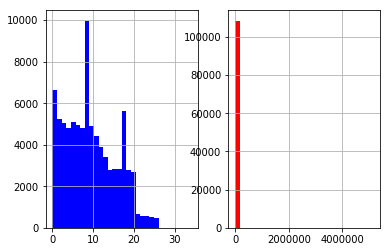

In [43]:
# plotting 3
fig3, axs3 = plt.subplots(1,2)
c.hist(ax=axs3[0], bins=30, color=['blue'])
d.hist(ax=axs3[1], bins=30, color=['red'])
fig3.savefig(title+'onclasssvm_train3.png')
plt.show();

In [48]:
"""# plotting 1 of anomaly in train
# 'Coun : number of connections to the same host'

fig4, ax4 = plt.subplots(figsize=(10,6))

f = train_df.loc[train_df['anomaly3'] == -1, ['timeseries', 'count']] #anomaly

ax4.plot(train_df['timeseries'], train_df['count'], color='blue', label ='Normal')
ax4.scatter(b['timeseries'], b['count'], color='red', label = 'Anomaly')
plt.legend() 
fig4.savefig(title+'onclasssvm_train4_count.png')
plt.show();  """ 

"# plotting 1 of anomaly in train\n# 'Coun : number of connections to the same host'\n\nfig4, ax4 = plt.subplots(figsize=(10,6))\n\nf = train_df.loc[train_df['anomaly3'] == -1, ['timeseries', 'count']] #anomaly\n\nax4.plot(train_df['timeseries'], train_df['count'], color='blue', label ='Normal')\nax4.scatter(b['timeseries'], b['count'], color='red', label = 'Anomaly')\nplt.legend() \nfig4.savefig(title+'onclasssvm_train4_count.png')\nplt.show();  "

In [47]:
"""# plotting 2
g = train_df.loc[train_df['anomaly3'] == 1, 'count']
h = train_df.loc[train_df['anomaly3'] == -1, 'count']

fig5, axs5 = plt.subplots(figsize=(10,6))
axs5.hist([c,d], bins=32, stacked=True, color=['blue', 'red'])
axs5.set_title("Anomaly Histogram of count column")
fig5.savefig(title+'onclasssvm_train5_count.png')
plt.show();"""

'# plotting 2\ng = train_df.loc[train_df[\'anomaly3\'] == 1, \'count\']\nh = train_df.loc[train_df[\'anomaly3\'] == -1, \'count\']\n\nfig5, axs5 = plt.subplots(figsize=(10,6))\naxs5.hist([c,d], bins=32, stacked=True, color=[\'blue\', \'red\'])\naxs5.set_title("Anomaly Histogram of count column")\nfig5.savefig(title+\'onclasssvm_train5_count.png\')\nplt.show();'

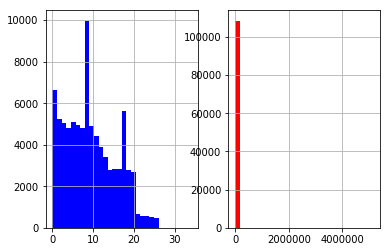

In [46]:
# plotting 3
fig6, axs6 = plt.subplots(1,2)
c.hist(ax=axs6[0], bins=30, color=['blue'])
d.hist(ax=axs6[1], bins=30, color=['red'])
fig6.savefig(title+'onclasssvm_train6_count.png')
plt.show();

In [ ]:
# end of code